## Pnet torch implementation

Our torch implementation of pnet does not produce the same results as the original tf implementation, even though I have captured every feature of the architecture I can find. The model is described in the "Methods" section of: https://www.nature.com/articles/s41586-021-03922-4. Things we have included below:

1. First layer is a "dense" layer, taking the 3 features for each gene and collapsing them into 1 latent variable. We then follow up with sparse NN layers.
2. Tanh activations between each pnet hidden layer
3. Each layer also has a linear layer with a sigmoid activation, producing a predictive output. The final prediction during training is a weighted sum of the losses of each of these intermediate predictive outputs, along with the final output of the network. The loss weights are the same as in the tf version.
4. They use a BCE loss
5. As far as I understand it, validation/test predictions do not use this weighted output, only the prediction of the final layer.
6. Adam optimizer, default lr=0.001

In [1]:
import time
import os
import numpy as np

import torch, torch_geometric.transforms as T, torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler, RandomSampler

from torch_geometric.loader import DataLoader

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    average_precision_score,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
)


from cancernet.util import ProgressBar, InMemoryLogger, get_roc
from cancernet import PnetDataSet, ReactomeNetwork
from cancernet.dataset import get_layer_maps
from cancernet.arch import PNet

In [2]:
reactome_kws = dict(
    reactome_base_dir=os.path.join("/mnt/home/cpedersen/ceph/Data/data", "reactome"),
    relations_file_name="ReactomePathwaysRelation.txt",
    pathway_names_file_name="ReactomePathways.txt",
    pathway_genes_file_name="ReactomePathways.gmt",
)
reactome = ReactomeNetwork(reactome_kws)

prostate_root = os.path.join("/mnt/home/cpedersen/ceph/Data/data", "prostate")
dataset = PnetDataSet(
    root=prostate_root,
    name="prostate_graph_humanbase",
    edge_tol=0.5,
    pre_transform=T.Compose(
        [T.GCNNorm(add_self_loops=False), T.ToSparseTensor(remove_edge_index=False)]
    )
)

# loads the train/valid/test split from pnet
splits_root = os.path.join(prostate_root, "splits")
dataset.split_index_by_file(
    train_fp=os.path.join(splits_root, "training_set_0.csv"),
    valid_fp=os.path.join(splits_root, "validation_set.csv"),
    test_fp=os.path.join(splits_root, "test_set.csv"),
)
#pl.seed_everything(42, workers=True)

n_epochs = 100
batch_size = 10
lr = 0.001
## Maps for pnet connections
maps = get_layer_maps(
    genes=[g for g in dataset.node_index],
    reactome=reactome,
    n_levels=2,
    direction="root_to_leaf",
    add_unk_genes=False,
    verbose=True,
)

train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.train_idx),
    drop_last=True
)
valid_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.valid_idx),
    drop_last=False
)

test_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(
        dataset.test_idx,
        generator=torch.Generator().manual_seed(43),
    ),
    drop_last=False,
)

layer # 0
pathways 146
genes 10621
filtered_map (9054, 0)
filtered_map (9054, 0)
filtered_map (9054, 0)
layer # 1
pathways 26
genes 147
filtered_map (146, 0)
filtered_map (146, 0)
filtered_map (146, 0)
layer # 2
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)


In [3]:
model = PNet(layers=maps, num_genes=maps[0].shape[0], lr=lr)

In [4]:
logger = InMemoryLogger()
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=0.00, patience=5, verbose=False, mode="min"
)
checkpoint_callback = ModelCheckpoint(
    dirpath="model_ckpts",
    monitor="val_loss",
    save_top_k=1,
    filename="bestmodel_pnet",
    mode="min",
)

bestmodel_file = os.path.join("model_ckpts", "bestmodel_pnet.ckpt")
if os.path.isfile(bestmodel_file):
    os.remove(bestmodel_file)
t0 = time.time()
# XXX this cannot be fully deterministic on GPU because
# XXX scatter_add_cuda_kernel does not have a deterministic implementation!
trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=n_epochs,
    callbacks=[ProgressBar(), early_stop_callback, checkpoint_callback],
    logger = logger,
)
trainer.fit(model, train_loader, valid_loader)
print(f"Training took {time.time() - t0:.1f} seconds.")
model = model.load_from_checkpoint(bestmodel_file)

/mnt/home/ttesileanu/miniconda3/envs/cancerenv/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mnt/home/ttesileanu/miniconda3/envs/cancerenv/lib/p ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/mnt/home/ttesileanu/miniconda3/envs/cancerenv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /mnt/home/ttesileanu/Documents/research/deep-cancer-conda/demos/model_ckpts exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training took 32.0 seconds.


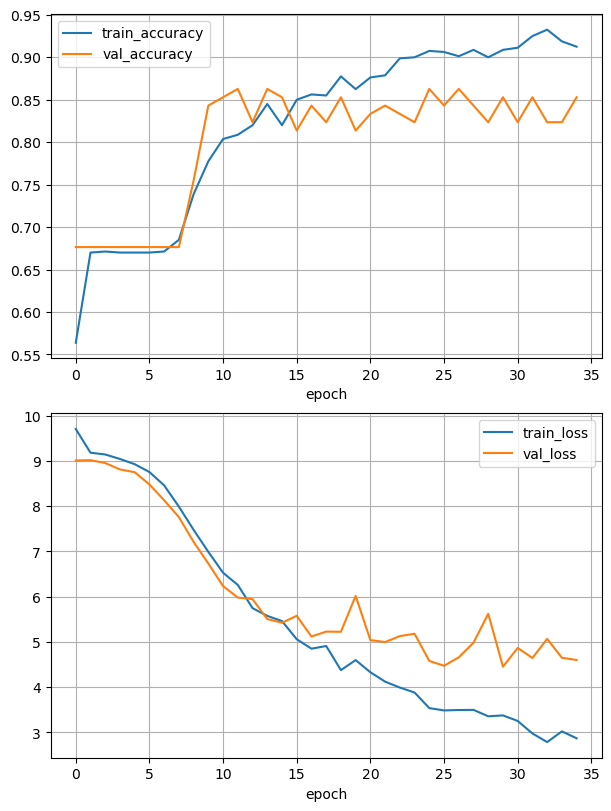

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), constrained_layout=True)
logger.metrics_df.plot("epoch", ["train_accuracy", "val_accuracy"], ax=ax1)
ax1.grid()

logger.metrics_df.plot("epoch", ["train_loss", "val_loss"], ax=ax2)
ax2.grid()

In [6]:
fpr_test, tpr_test, test_auc, ys, outs = get_roc(model, test_loader, exp=False)
test_acc = accuracy_score(ys, outs[:, 1] > 0.5)
test_aupr = average_precision_score(ys, outs[:, 1])
test_f1 = f1_score(ys, outs[:, 1] > 0.5)
test_precision = precision_score(ys, outs[:, 1] > 0.5)
test_recall = recall_score(ys, outs[:, 1] > 0.5)

print("accuracy", test_acc)
print("auc", test_auc)
print("aupr", test_aupr)
print("f1", test_f1)
print("precision", test_precision)
print("recall", test_recall)

accuracy 0.8431372549019608
auc 0.9411764705882353
aupr 0.8788472605860804
f1 0.7419354838709677
precision 0.8214285714285714
recall 0.6764705882352942
